
# Convolutional Neural Network (CNN) — Visual Guide (Digits 8×8)

This notebook trains a **small CNN** on the local `sklearn` **Digits** dataset (8×8 grayscale, 10 classes).
It avoids any network downloads. If TensorFlow/Keras is unavailable, a clear message will appear with a one‑liner to install it.

What you’ll see:
- Data prep (train/val/test, normalization, one‑hot labels)
- A **baseline CNN** (Conv → ReLU → Pool → Conv → ReLU → Flatten → Dense)
- **Training curves** (loss/accuracy vs epochs)
- **Confusion matrix** on test set
- **Misclassified examples** (quick audit)
- A simple **saliency** view (input gradients)
- A small **hyperparameter sweep** (filters & dropout) for intuition

> Tip: Digits are only 8×8; this is meant to be a lightweight CNN demo you can run anywhere.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Try to import TensorFlow/Keras; if not available, we will skip training cells with guidance.
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
    print("TensorFlow version:", tf.__version__)
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow/Keras not available. To enable training here, run:")
    print("  pip install tensorflow-cpu  # or tensorflow")
    print("Cells that require TF will be skipped.")

# Load the 8x8 digits (no internet needed)
digits = load_digits()
X = digits.images  # shape (n, 8, 8)
y = digits.target  # 0..9

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
X_val, X_test,  y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7, stratify=y_temp)

# Normalize to [0,1] and add channel dim
X_train = (X_train / 16.0).astype("float32")[..., None]
X_val   = (X_val   / 16.0).astype("float32")[..., None]
X_test  = (X_test  / 16.0).astype("float32")[..., None]

num_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, num_classes) if TF_AVAILABLE else None
y_val_cat   = keras.utils.to_categorical(y_val,   num_classes) if TF_AVAILABLE else None
y_test_cat  = keras.utils.to_categorical(y_test,  num_classes) if TF_AVAILABLE else None

print("Shapes — train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

TensorFlow version: 2.19.0
Shapes — train: (1257, 8, 8, 1) val: (270, 8, 8, 1) test: (270, 8, 8, 1)


## Build a baseline CNN

In [ ]:
def build_cnn(filters1=16, filters2=32, dropout=0.0, lr=1e-3):
    if not TF_AVAILABLE:
        return None
    inputs = keras.Input(shape=(8,8,1))
    x = layers.Conv2D(filters1, (3,3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(filters2, (3,3), padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

if TF_AVAILABLE:
    model = build_cnn()
    model.summary()
else:
    print("Skipping model.summary() — TensorFlow not available.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 16)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,282 (149.54 KB)

 Trainable params: 38,282 (149.54 KB)

 Non-trainable params: 0 (0.00 B)

## Train (with early stopping)

In [ ]:
if TF_AVAILABLE:
    es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
    hist = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                     epochs=60, batch_size=64, verbose=0, callbacks=[es])
    print("Best val acc:", max(hist.history["val_accuracy"]))
else:
    print("Skipping training — TensorFlow not available.")

Best val acc: 0.9925925731658936


## Training curves (loss / accuracy)

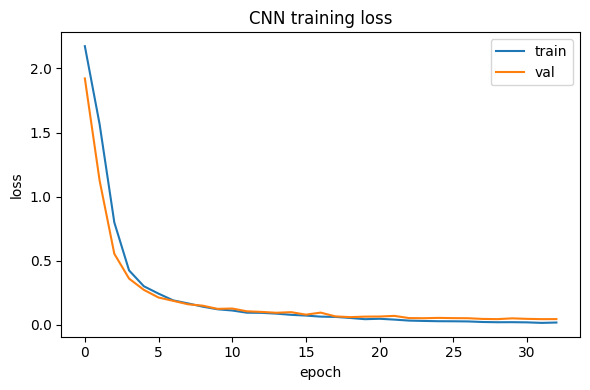

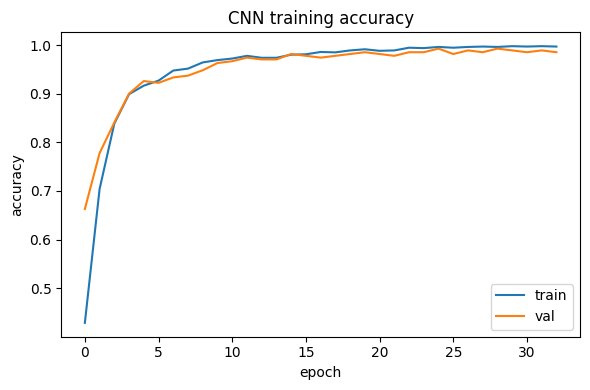

In [ ]:
if TF_AVAILABLE:
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("CNN training loss")
    plt.legend(); plt.tight_layout(); plt.show()

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["accuracy"], label="train")
    plt.plot(hist.history["val_accuracy"], label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("CNN training accuracy")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Skipping curves — TensorFlow not available.")

## Evaluation — test metrics & confusion matrix

              precision    recall  f1-score   support

           0      0.964     1.000     0.982        27
           1      0.933     1.000     0.966        28
           2      1.000     1.000     1.000        26
           3      0.962     0.926     0.943        27
           4      1.000     0.963     0.981        27
           5      0.931     0.964     0.947        28
           6      1.000     0.963     0.981        27
           7      1.000     1.000     1.000        27
           8      0.962     0.962     0.962        26
           9      0.962     0.926     0.943        27

    accuracy                          0.970       270
   macro avg      0.971     0.970     0.971       270
weighted avg      0.971     0.970     0.970       270



<Figure size 600x500 with 0 Axes>

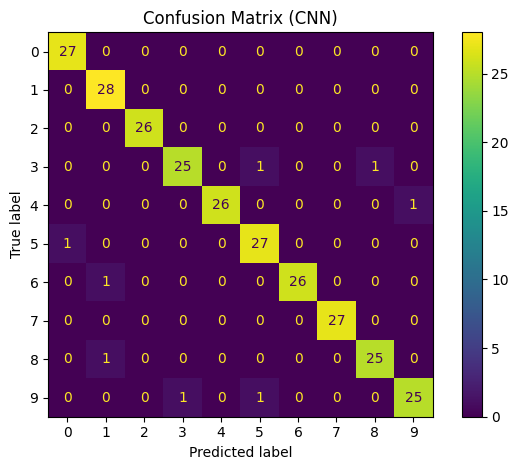

In [ ]:
if TF_AVAILABLE:
    test_probs = model.predict(X_test, verbose=0)
    y_pred = test_probs.argmax(axis=1)
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(range(10)))
    plt.figure(figsize=(6,5)); disp.plot(values_format="d"); plt.title("Confusion Matrix (CNN)"); plt.tight_layout(); plt.show()
else:
    print("Skipping evaluation — TensorFlow not available.")

## Misclassified examples

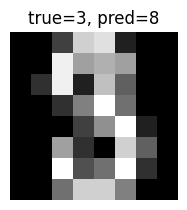

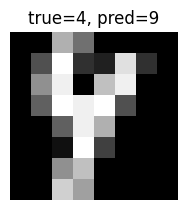

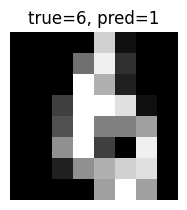

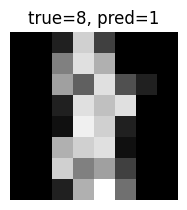

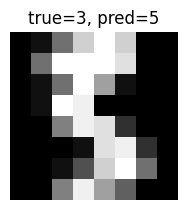

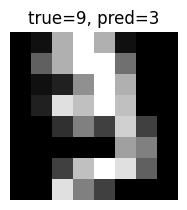

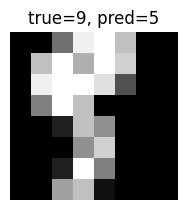

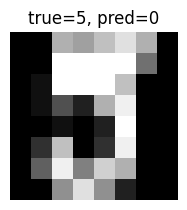

In [ ]:
if TF_AVAILABLE:
    wrong = np.where(y_pred != y_test)[0]
    if len(wrong) == 0:
        print("No misclassifications — nice!")
    else:
        idxs = wrong[:16]
        for i in idxs:
            plt.figure(figsize=(2.2,2.2))
            plt.imshow(X_test[i].squeeze(), cmap="gray")
            plt.title(f"true={y_test[i]}, pred={y_pred[i]}")
            plt.axis("off"); plt.tight_layout(); plt.show()
else:
    print("Skipping — TensorFlow not available.")

## Saliency (input gradients wrt true class)

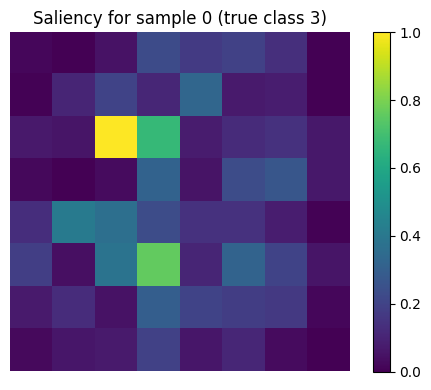

In [ ]:
if TF_AVAILABLE:
    # Pick a test sample
    i = 0
    x = tf.convert_to_tensor(X_test[i:i+1])  # shape (1,8,8,1)
    y_true_cls = y_test[i]

    with tf.GradientTape() as tape:
        tape.watch(x)
        probs = model(x, training=False)
        loss = probs[:, y_true_cls]  # probability of the true class
    grads = tape.gradient(loss, x).numpy()[0].squeeze()

    # Normalize for display
    g = np.abs(grads)
    g = (g - g.min()) / (np.ptp(g) + 1e-9)

    plt.figure(figsize=(5,4))
    plt.imshow(g, cmap="viridis"); plt.colorbar()
    plt.title(f"Saliency for sample {i} (true class {y_true_cls})")
    plt.axis("off"); plt.tight_layout(); plt.show()
else:
    print("Skipping saliency — TensorFlow not available.")

## Tiny hyperparameter sweep (filters & dropout)

In [ ]:
if TF_AVAILABLE:
    trials = [
        {"filters1":8,  "filters2":16, "dropout":0.0},
        {"filters1":16, "filters2":32, "dropout":0.0},
        {"filters1":16, "filters2":32, "dropout":0.3},
        {"filters1":32, "filters2":64, "dropout":0.3},
    ]
    results = []
    for t in trials:
        m = build_cnn(**t)
        es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
        h = m.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                  epochs=40, batch_size=64, verbose=0, callbacks=[es])
        te_probs = m.predict(X_test, verbose=0)
        te_pred  = te_probs.argmax(axis=1)
        acc = (te_pred == y_test).mean()
        results.append({"filters1":t["filters1"], "filters2":t["filters2"], "dropout":t["dropout"],
                        "val_best": max(h.history["val_accuracy"]), "test_acc": acc})
        print(results[-1])
    # Tabulate
    df = pd.DataFrame(results)
    print(df)
else:
    print("Skipping sweep — TensorFlow not available.")

{'filters1': 8, 'filters2': 16, 'dropout': 0.0, 'val_best': 0.9777777791023254, 'test_acc': np.float64(0.9666666666666667)}
{'filters1': 16, 'filters2': 32, 'dropout': 0.0, 'val_best': 0.9888888597488403, 'test_acc': np.float64(0.9740740740740741)}
{'filters1': 16, 'filters2': 32, 'dropout': 0.3, 'val_best': 0.9925925731658936, 'test_acc': np.float64(0.9814814814814815)}
{'filters1': 32, 'filters2': 64, 'dropout': 0.3, 'val_best': 0.9962962865829468, 'test_acc': np.float64(0.9814814814814815)}
   filters1  filters2  dropout  val_best  test_acc
0         8        16      0.0  0.977778  0.966667
1        16        32      0.0  0.988889  0.974074
2        16        32      0.3  0.992593  0.981481
3        32        64      0.3  0.996296  0.981481
